In [97]:
# DO ANY PASSES OVERLAP

In [209]:
# Import necessary libraries
import ephem
import math
from datetime import timedelta


# get_passes() function definition
def new_get_passes(observer, tle, start_time, num_passes=None, duration=None):
    """Config obs and sat, Return pass data for all passes in given interval.

    Arguments:
    observer -- 4 element list containing desired [name,lat,lon,alt]
    tle -- 3 element list containing desired tle [line0,line1,line2]
    start_time -- ephem.date string formatted 'yyyy/mm/dd hr:min:sec'
    num_passes -- integer number of desired passes (defualt None)
    duration -- float number of hours or fraction of hours (default None)

    Specify either num_passes or duration.
    If both, use min(num_passes, duration).
    If neither, find passes for next 24 hours.
    """

    obs_name, obs_lat, obs_lon, obs_alt = observer
    tle_line0, tle_line1, tle_line2 = tle

    # Set up location of observer
    ground_station = ephem.Observer()
    ground_station.name = obs_name                # name string
    ground_station.lon = obs_lon                  # in degrees (+E)
    ground_station.lat = obs_lat                  # in degrees (+N)
    ground_station.elevation = obs_alt            # in meters
    ground_station.date = ephem.date(start_time)  # in UTC

    # Read in most recent satellite TLE data
    sat = ephem.readtle(tle_line0, tle_line1, tle_line2)

    contacts = []

    if duration is None and num_passes is None:
        # get passes for next 24 hrs
        duration = 24
        # set num_passes > max passes possible in duration.
        # duration is in hours, so 4 per hour is large
        # enough for duration to break out of loop.
        num_passes = 4 * int(duration)
        # set end_time longer than suggested length for tle's
        end_time = ephem.date(ground_station.date+5*365)
    if duration is not None and num_passes is None:
        # set num_passes > max passes possible in duration.
        # duration is in hours, so 4 per hour is large
        # enough for duration to break out of loop.
        num_passes = 4 * int(duration)
        end_time = ephem.date(ground_station.date+duration*ephem.hour)
    if duration is None and num_passes is not None:
        # set end_time longer than suggested length for tle's
        end_time = ephem.date(ground_station.date+5*365)
    if num_passes is not None and duration is not None:
        # if both are given, use minimum
        end_time = ephem.date(ground_station.date+duration*ephem.hour)

    try:
        for i in range(num_passes):
            if ground_station.date > end_time:
                break
            sat.compute(ground_station)  # compute all body attributes for sat
            # next pass command yields array with [0]=rise time,
            # [1]=rise azimuth, [2]=max alt time, [3]=max alt,
            # [4]=set time, [5]=set azimuth
            info = ground_station.next_pass(sat)
            rise_time, rise_az, max_alt_time, max_alt, set_time, set_az = info
            deg_per_rad = 180.0/math.pi           # use to conv azimuth to deg
            try:
                pass_duration = timedelta(days=set_time-rise_time)  # timedelta
                r_angle = (rise_az*deg_per_rad)
                s_angle = (set_az*deg_per_rad)
            except TypeError:
                # when no set or rise time
                pass
            try:
                rising = rise_time.datetime().ctime()
                setting = set_time.datetime().ctime()
                pass_seconds = timedelta.total_seconds(pass_duration)
            except AttributeError:
                # when no set or rise time
                pass

            pass_data = {
                'start': rising,
                'end': setting,
                'duration': pass_seconds,
                'rise_az': r_angle,
                'set_az': s_angle,
            }

            try:
                if set_time > rise_time:  # only update if set time > rise time
                    ground_station.date = set_time  # new obs time = prev set time
                    if ground_station.date <= end_time:
                        contacts.append(pass_data)
            except TypeError:
                pass

            # increase by 1 min and look for next pass
            ground_station.date = ground_station.date + ephem.minute
    except ValueError:
        # No (more) visible passes
        pass
    return contacts


In [175]:
from itertools import islice
data = []
with open('amateur.txt') as f:
    while True:
        #an iterator that returns the next N lines and stops
        tripleline = islice(f, 3)
        #loop over these N lines, removing trailing spaces and \n
        tle = [x.rstrip() for x in tripleline]

        #only accept complete data
        #the end of the file *should* have len(tle)==0 but
        #this also handles extra junk at the end
        if len(tle) == 3:
            data.append(tle)
        else:
            break


In [176]:
vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
start_time = '2017/6/8 00:00:00'
num_passes = None
duration = 24.0
vu_passes = {}

for tle in data:
    # use NORAD ID as key for each satellite
    # value is list of passes, where each pass is a dictionary of data
    noradID = tle[2][2:7]
    vu_passes[noradID] = new_get_passes(vu, tle, start_time, num_passes=num_passes, duration=duration)

    

In [177]:
a = [len(data),int(duration)]
a

[74, 24]

In [178]:
for sat, passes in vu_passes.items():
    for obs in passes:
        print('NORAD ID:', sat, 'START:', obs['start'], 'END:', obs['end'])


NORAD ID: 22826 START: Thu Jun  8 07:04:59 2017 END: Thu Jun  8 07:09:22 2017
NORAD ID: 22826 START: Thu Jun  8 08:40:31 2017 END: Thu Jun  8 08:55:26 2017
NORAD ID: 22826 START: Thu Jun  8 10:20:08 2017 END: Thu Jun  8 10:34:30 2017
NORAD ID: 22826 START: Thu Jun  8 12:02:07 2017 END: Thu Jun  8 12:08:08 2017
NORAD ID: 22826 START: Thu Jun  8 18:22:46 2017 END: Thu Jun  8 18:32:55 2017
NORAD ID: 22826 START: Thu Jun  8 19:58:38 2017 END: Thu Jun  8 20:13:46 2017
NORAD ID: 22826 START: Thu Jun  8 21:39:19 2017 END: Thu Jun  8 21:52:43 2017
NORAD ID: 32789 START: Thu Jun  8 01:17:11 2017 END: Thu Jun  8 01:26:55 2017
NORAD ID: 32789 START: Thu Jun  8 02:50:04 2017 END: Thu Jun  8 03:02:31 2017
NORAD ID: 32789 START: Thu Jun  8 04:28:19 2017 END: Thu Jun  8 04:35:15 2017
NORAD ID: 32789 START: Thu Jun  8 14:27:17 2017 END: Thu Jun  8 14:38:00 2017
NORAD ID: 32789 START: Thu Jun  8 16:01:35 2017 END: Thu Jun  8 16:13:35 2017
NORAD ID: 32789 START: Thu Jun  8 17:38:40 2017 END: Thu Jun  8 

 Thu Jun  8 00:49:18 2017
NORAD ID: 39440 START: Thu Jun  8 02:14:12 2017 END: Thu Jun  8 02:25:07 2017
NORAD ID: 39440 START: Thu Jun  8 12:26:39 2017 END: Thu Jun  8 12:38:42 2017
NORAD ID: 39440 START: Thu Jun  8 14:02:34 2017 END: Thu Jun  8 14:16:45 2017
NORAD ID: 39440 START: Thu Jun  8 15:40:33 2017 END: Thu Jun  8 15:50:01 2017
NORAD ID: 39440 START: Thu Jun  8 23:25:53 2017 END: Thu Jun  8 23:36:30 2017
NORAD ID: 41789 START: Thu Jun  8 01:32:42 2017 END: Thu Jun  8 01:44:46 2017
NORAD ID: 41789 START: Thu Jun  8 03:08:29 2017 END: Thu Jun  8 03:22:39 2017
NORAD ID: 41789 START: Thu Jun  8 04:49:37 2017 END: Thu Jun  8 04:57:52 2017
NORAD ID: 41789 START: Thu Jun  8 15:04:39 2017 END: Thu Jun  8 15:17:58 2017
NORAD ID: 41789 START: Thu Jun  8 16:42:04 2017 END: Thu Jun  8 16:54:54 2017
NORAD ID: 41789 START: Thu Jun  8 18:22:51 2017 END: Thu Jun  8 18:25:37 2017
NORAD ID: 41459 START: Thu Jun  8 00:22:53 2017 END: Thu Jun  8 00:34:19 2017
NORAD ID: 41459 START: Thu Jun  8 01:5

NORAD ID: 32953 START: Thu Jun  8 12:48:20 2017 END: Thu Jun  8 12:57:02 2017
NORAD ID: 32953 START: Thu Jun  8 14:42:54 2017 END: Thu Jun  8 15:04:36 2017
NORAD ID: 32953 START: Thu Jun  8 16:39:34 2017 END: Thu Jun  8 17:03:14 2017
NORAD ID: 32953 START: Thu Jun  8 18:37:47 2017 END: Thu Jun  8 18:55:17 2017
NORAD ID: 40958 START: Thu Jun  8 02:00:11 2017 END: Thu Jun  8 02:09:23 2017
NORAD ID: 40958 START: Thu Jun  8 03:33:52 2017 END: Thu Jun  8 03:47:26 2017
NORAD ID: 40958 START: Thu Jun  8 05:12:27 2017 END: Thu Jun  8 05:23:14 2017
NORAD ID: 40958 START: Thu Jun  8 15:26:03 2017 END: Thu Jun  8 15:37:33 2017
NORAD ID: 40958 START: Thu Jun  8 17:02:09 2017 END: Thu Jun  8 17:15:34 2017
NORAD ID: 40958 START: Thu Jun  8 18:40:29 2017 END: Thu Jun  8 18:48:40 2017
NORAD ID: 23439 START: Thu Jun  8 03:04:37 2017 END: Thu Jun  8 03:29:09 2017
NORAD ID: 23439 START: Thu Jun  8 05:11:28 2017 END: Thu Jun  8 05:42:58 2017
NORAD ID: 23439 START: Thu Jun  8 07:25:15 2017 END: Thu Jun  8 

In [210]:
year = 365
start_time = ephem.date('2017/6/8 00:00:00')
access_list = []
day_list = []
for days in range(year):
    vu = ['Valparaiso University', '41.4639', '-87.0439', 245.089]
    num_passes = None
    duration = 24.0
    vu_passes = {}

    #print(start_time)

    for tle in data:
        # use NORAD ID as key for each satellite
        # value is list of passes, where each pass is a dictionary of data
        noradID = tle[2][2:7]
        vu_passes[noradID] = new_get_passes(vu, tle, start_time, num_passes=num_passes, duration=duration)

    access_time = 0
    for sat, passes in vu_passes.items():
        for obs in passes:
            access_time = access_time + obs['duration']
    access_list.append(access_time)
    day_list.append(days)
    start_time = start_time + 1



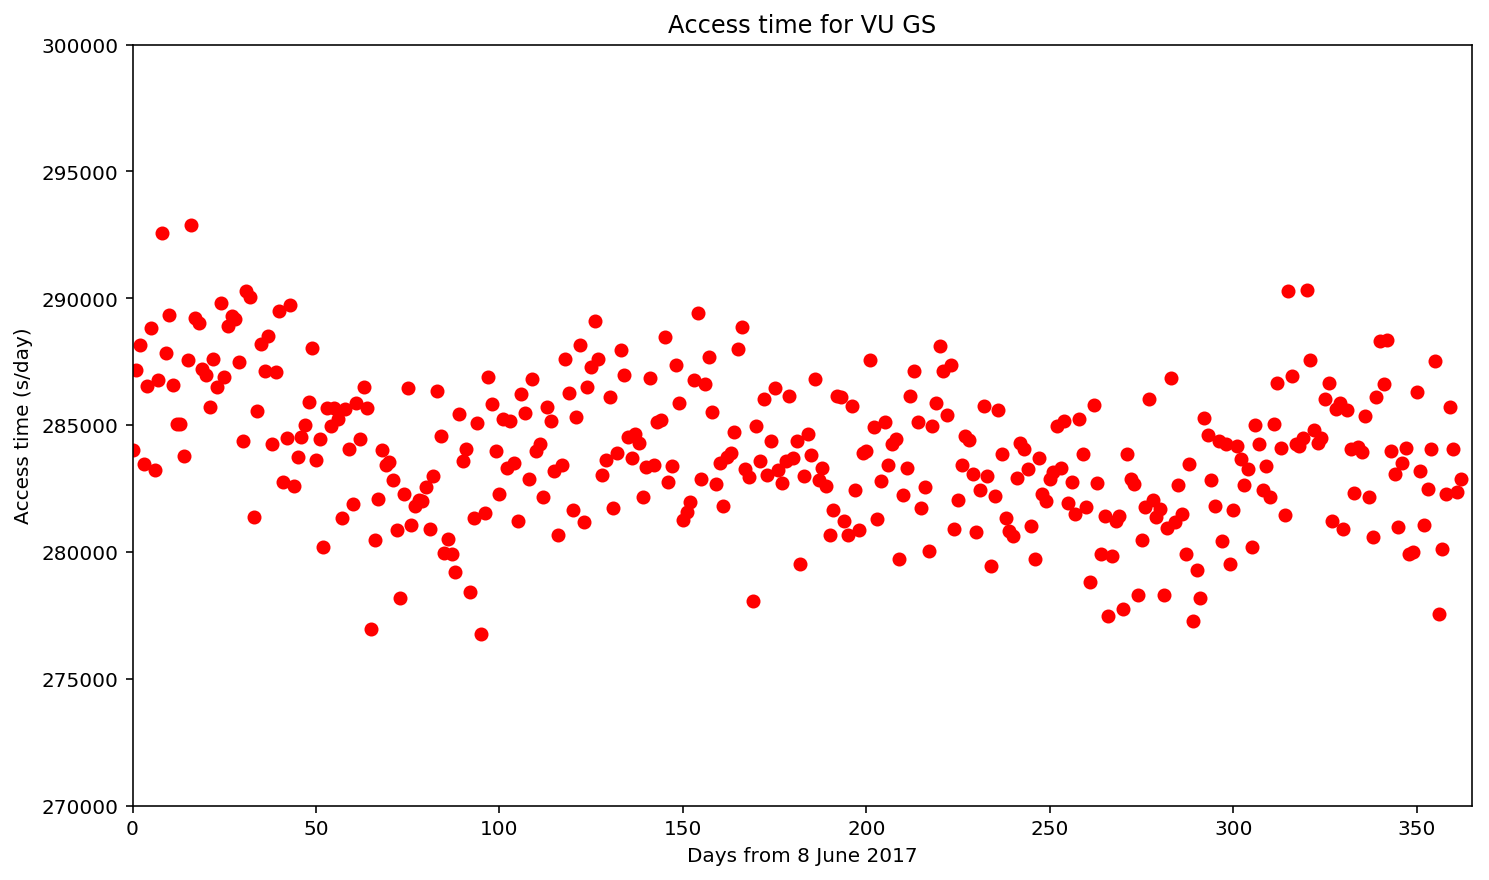

In [222]:
import matplotlib.pyplot as plt


plt.plot(day_list, access_list, 'ro')
plt.title('Access time for VU GS')
plt.xlabel('Days from 8 June 2017')
plt.ylabel('Access time (s/day)')
plt.axis([0,365,270000,300000])
plt.show()